# DeepWeeds - MobileNet

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

seed = 999
def seedEverything(seed, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    tf.keras.utils.set_random_seed(seed)

    if deterministic:
        tf.config.experimental.enable_op_determinism()

        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        tf.config.threading.set_inter_op_parallelism_threads(1)
        tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(seed, True)

2024-06-04 09:18:13.645360: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 09:18:13.645454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 09:18:13.777002: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [3]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/deepweeds/labels.csv") ## For Kaggle
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [4]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [5]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [6]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

# Splitting Data into Train:Valid:Test Splits (60:20:20)

In [7]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 0 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])

# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 1 out of 5 folds
-------------------------------------------------



In [8]:
train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
train_data.rename(columns={"Label":"label"}, inplace=True)

valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  675  637  618  613  637  605  644  609  5463 	Total: (10501, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1821 	Total: (3501, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  226  213  207  205  213  202  215  204  1822 	Total: (3507, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [9]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    prediction = np.asarray(prediction)
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Creating Dateset ImageGenerator

In [11]:
IMG_SIZE=(256,256,3)
oversampling = 0 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/deepweeds/images" ## For Kaggle
base_dir = "/kaggle/working/deepweeds_9c" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [12]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

Found 10501 files belonging to 9 classes.
Found 3501 files belonging to 9 classes.
Found 3507 files belonging to 9 classes.


# Sample Images

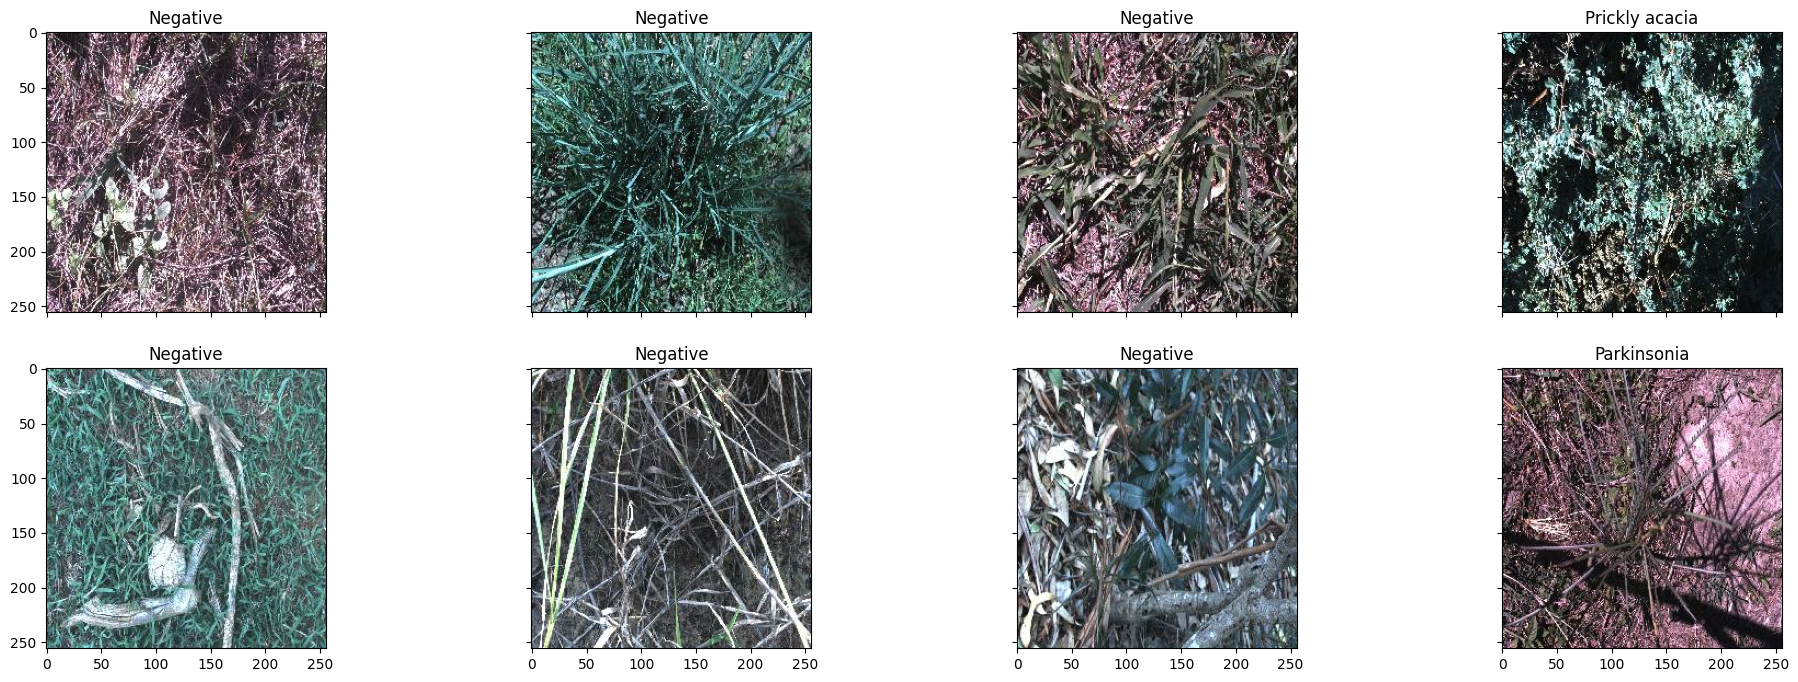

In [13]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

In [14]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

class SpatialMaxPooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialMaxPooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.max = tf.keras.layers.MaxPool1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.max(x)
        x = self.reshape_backward(x)
        return x

class SpatialAveragePooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialAveragePooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.avg = tf.keras.layers.AveragePooling1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.avg(x)
        x = self.reshape_backward(x)
        return x

def AverageOfMaximums(x, max_pool_size=2, layer_num=1):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num))(_max)
    return _avg

In [15]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros',
                           name='Dense_Squeeze_CA')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros',
                           name='Dense_Excite_CA')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)

    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)

    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)

    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)

    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)

    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])



def spatial_attention(input_feature):
    kernel_size = 5

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1

    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1

    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2

    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [16]:
def ModifiedSpatialAttention(input_feature, kernel_size=5, num_pooled_channel=8, layer_num = 0):
    in_shape = input_feature.shape
    #pool_size =  in_shape[-1] // num_pooled_channel

    channel_avg = layers.Dense(num_pooled_channel, name="MSA_Feature_1L{}".format(layer_num))(input_feature)
    channel_max = layers.Dense(num_pooled_channel , name='MSA_Feature_2L{}'.format(layer_num))(input_feature)


    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    concat = Concatenate(axis=3)([channel_avg, channel_max])

    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [17]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

# Building MobileNet Model

In [18]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    return keras.Sequential([
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        layers.RandomRotation(0.5, seed=seed, name='RR_Rot'),
        layers.RandomTranslation(0.4, 0.4, seed=seed, name='RR_Trans'),
        layers.RandomZoom(0.2, 0.2, seed=seed, name='RR_Zoom'),
        layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model

def hard_swish(x):
    relu6 = layers.ReLU(max_value=6)
    return x * (relu6(x + 3) / 6)

def MobilenetV3Base(img_size, use='S'): # use = S (small) or L (large)
    # Load the MobileNet model with weights pre-trained on ImageNet.
    if(use=='S'):
        mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet')
    if(use=='L'):
        mobilenet = MobileNetV3Large(input_shape=img_size, weights='imagenet')
    mobilenet.trainable = True

    base_model =  keras.Model(inputs=mobilenet.layers[0].input, outputs=mobilenet.layers[-11].output, name = mobilenet.name+"_base_")
    base_model.trainable = True

    pooler = mobilenet.layers[-9]

    return base_model , pooler

def buildModel(IMG_SIZE):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, pooler = MobilenetV3Base((224,224,3), use='S')
    base_model.trainable = True
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    
    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    x = layers.Rescaling(1./255, name='PP_Rescale')(inputs)
    x = layers.Resizing(224, 224, name='PP_Resize')(x)

    x = augment(seed)(x)
    x = base_model(x, training=True)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(9, activation='softmax')(x)

    model_name = "CottonWeed15-" + base_model.name
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

    return model

In [19]:
# IMG_SIZE = (256,256,3)
# seed = 42
model = buildModel(IMG_SIZE)
model.summary()

10734624/10734624 [==============================] - 1s 0us/step
Base Model: MobilenetV3small_base_
229
Model: "CottonWeed15-MobilenetV3small_base_"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 PP_Rescale (Rescaling)      (None, 256, 256, 3)       0         
                                                                 
 PP_Resize (Resizing)        (None, 224, 224, 3)       0         
                                                                 
 augment_pipeline (Sequenti  (None, 224, 224, 3)       0         
 al)                                                             
                                                                 
 MobilenetV3small_base_ (Fu  (None, 7, 7, 576)         939120    
 nctional)                                                 

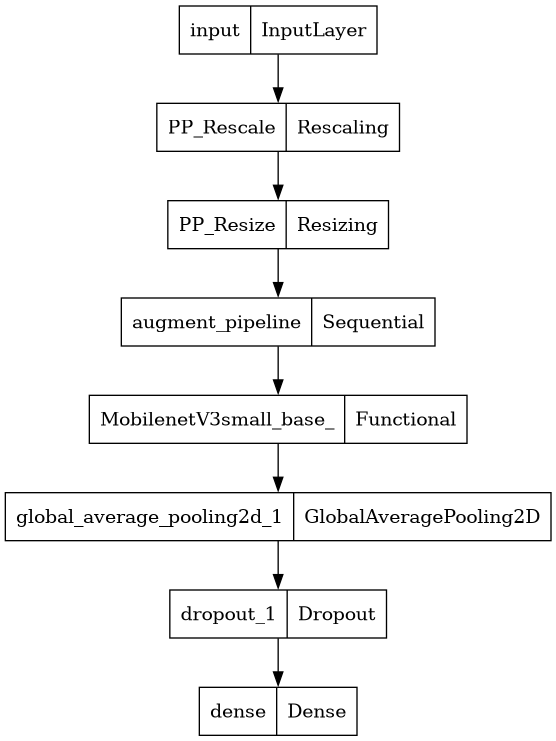

In [20]:
tf.keras.utils.plot_model(model)

# Trial 1 - FineTuning

In [21]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Constant for epochs
EPOCHS = 200

pat_es = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-6)

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-4,  weight_decay=5e-2),
          metrics=['accuracy'])
# weights = getWeightedClass(data_info, 1/3)
# weights

Epoch 1/200


I0000 00:00:1717492835.842765      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 [==============================] - 55s 77ms/step - loss: 1.3530 - accuracy: 0.5465 - val_loss: 0.9361 - val_accuracy: 0.6718 - lr: 2.0000e-04
Epoch 2/200
329/329 [==============================] - 24s 72ms/step - loss: 0.9833 - accuracy: 0.6558 - val_loss: 0.7263 - val_accuracy: 0.7398 - lr: 2.0000e-04
Epoch 3/200
329/329 [==============================] - 24s 72ms/step - loss: 0.8220 - accuracy: 0.7111 - val_loss: 0.6078 - val_accuracy: 0.7875 - lr: 2.0000e-04
Epoch 4/200
329/329 [==============================] - 24s 73ms/step - loss: 0.7268 - accuracy: 0.7445 - val_loss: 0.5348 - val_accuracy: 0.8149 - lr: 2.0000e-04
Epoch 5/200
329/329 [==============================] - 23s 71ms/step - loss: 0.6479 - accuracy: 0.7738 - val_loss: 0.5107 - val_accuracy: 0.8318 - lr: 2.0000e-04
Epoch 6/200
329/329 [==============================] - 23s 70ms/step - loss: 0.6071 - accuracy: 0.7882 - val_loss: 0.4468 - val_accuracy: 0.8475 - lr: 2.0000e-04
Epoch 7/200
329/329 [===================

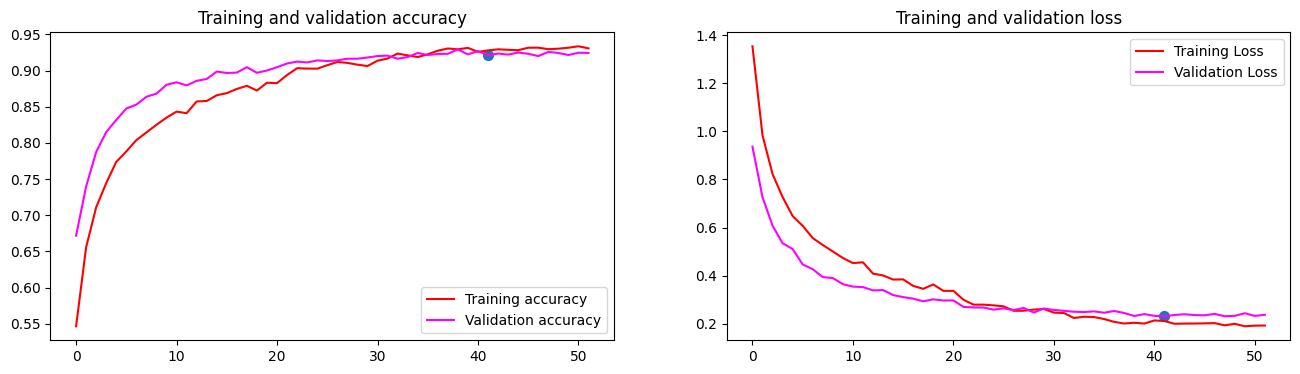

CPU times: user 32min 19s, sys: 2min 5s, total: 34min 24s
Wall time: 21min 25s


In [22]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history1.history)

# Evaluation

model.evaluate
110/110 [==============================] - 3s 23ms/step - loss: 0.2309 - accuracy: 0.9217
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.80435   0.82222   0.81319       225
       Lantana    0.94898   0.87324   0.90954       213
   Parkinsonia    0.95673   0.96602   0.96135       206
    Parthenium    0.92347   0.88725   0.90500       204
Prickly acacia    0.92417   0.91981   0.92199       212
   Rubber vine    0.93659   0.95050   0.94349       202
     Siam weed    0.92157   0.87442   0.89737       215
    Snake weed    0.85052   0.81281   0.83123       203
      Negative    0.93753   0.95607   0.94671      1821

      accuracy                        0.92316      3501
     macro avg    0.91154   0.89582   0.90332      3501
  weighted avg    0.92309   0.92316   0.92289      3501


                False Positive Rate  Accuracy
Chinee apple               0.013736  0.822222
Lantana                    0.003041  0.873239
Parkinsonia                0.002731  0.966019
Parthenium                 0.004550  0.887255
Prickly acacia    

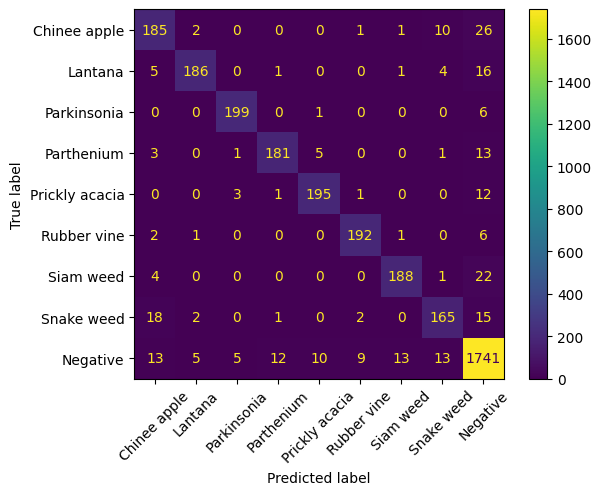

In [23]:
a, b = eval_model(model, validation_generator)

model.evaluate
110/110 [==============================] - 3s 25ms/step - loss: 3.5625 - accuracy: 0.4642
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.10811   0.07080   0.08556       226
       Lantana    0.05195   0.01878   0.02759       213
   Parkinsonia    0.31250   0.04831   0.08368       207
    Parthenium    0.20339   0.05854   0.09091       205
Prickly acacia    0.23404   0.05164   0.08462       213
   Rubber vine    0.10843   0.04455   0.06316       202
     Siam weed    0.17857   0.04651   0.07380       215
    Snake weed    0.18367   0.08824   0.11921       204
      Negative    0.52907   0.84413   0.65045      1822

      accuracy                        0.46421      3507
     macro avg    0.21219   0.14128   0.14211      3507
  weighted avg    0.35742   0.46421   0.37561      3507


                False Positive Rate  Accuracy
Chinee apple               0.040232  0.070796
Lantana                    0.022162  0.018779
Parkinsonia                0.006667  0.048309
Parthenium                 0.014234  0.058537
Prickly acacia    

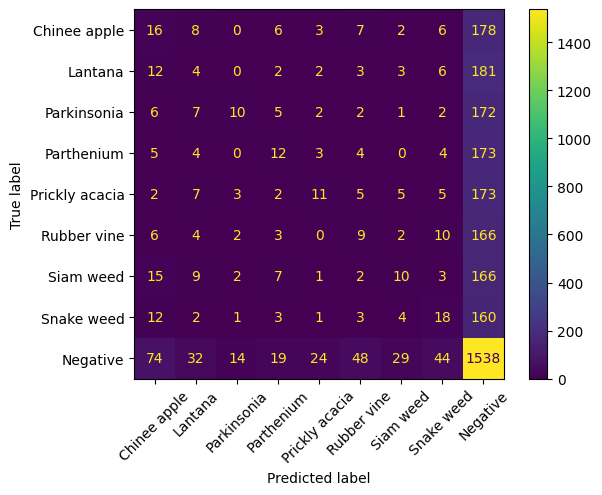

In [24]:

a, b = eval_model(model, test_generator)

# Trial 2 - Freezing Base Model

Freezing Layer MobilenetV3small_base_
Epoch 1/200
329/329 [==============================] - 19s 44ms/step - loss: 1.2830 - accuracy: 0.6533 - val_loss: 1.1016 - val_accuracy: 0.7184 - lr: 1.0000e-06
Epoch 2/200
329/329 [==============================] - 13s 39ms/step - loss: 1.2571 - accuracy: 0.6601 - val_loss: 1.0921 - val_accuracy: 0.7207 - lr: 1.0000e-06
Epoch 3/200
329/329 [==============================] - 14s 41ms/step - loss: 1.2541 - accuracy: 0.6565 - val_loss: 1.0827 - val_accuracy: 0.7215 - lr: 1.0000e-06
Epoch 4/200
329/329 [==============================] - 13s 39ms/step - loss: 1.2551 - accuracy: 0.6553 - val_loss: 1.0735 - val_accuracy: 0.7232 - lr: 1.0000e-06
Epoch 5/200
329/329 [==============================] - 13s 40ms/step - loss: 1.2547 - accuracy: 0.6608 - val_loss: 1.0644 - val_accuracy: 0.7261 - lr: 1.0000e-06
Epoch 6/200
329/329 [==============================] - 13s 39ms/step - loss: 1.2205 - accuracy: 0.6579 - val_loss: 1.0557 - val_accuracy: 0.7281 - lr: 1

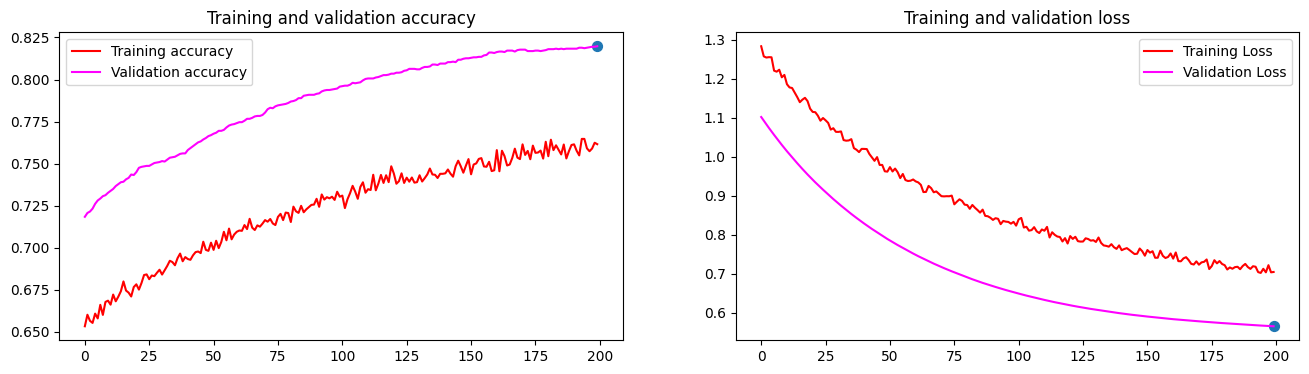

In [25]:
# weights = getWeightedClass(data_info, 1/2)
# print("Using Class-Weights",weights)

for layer in model.layers:
    if('mobilenet' in layer.name.lower()):
        print("Freezing Layer", layer.name)
        layer.trainable = False
        break

model.compile(loss='categorical_crossentropy',
  optimizer=AdamW(learning_rate=1e-6,  weight_decay=5e-4),
  metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=5e-7)
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping,reduce_lr]
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history2.history)

# Accuracy / Loss Plots

Total Epochs: range(0, 252)


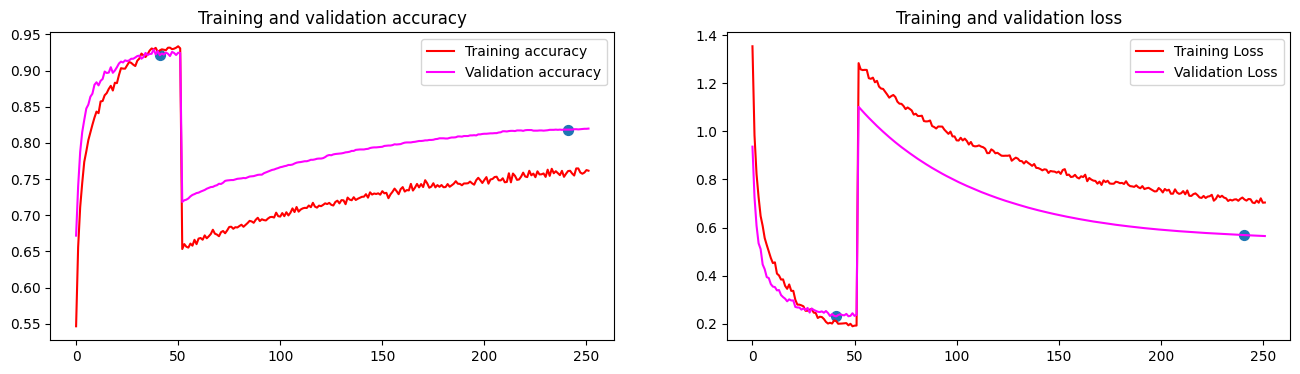

In [26]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es +=1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 52)


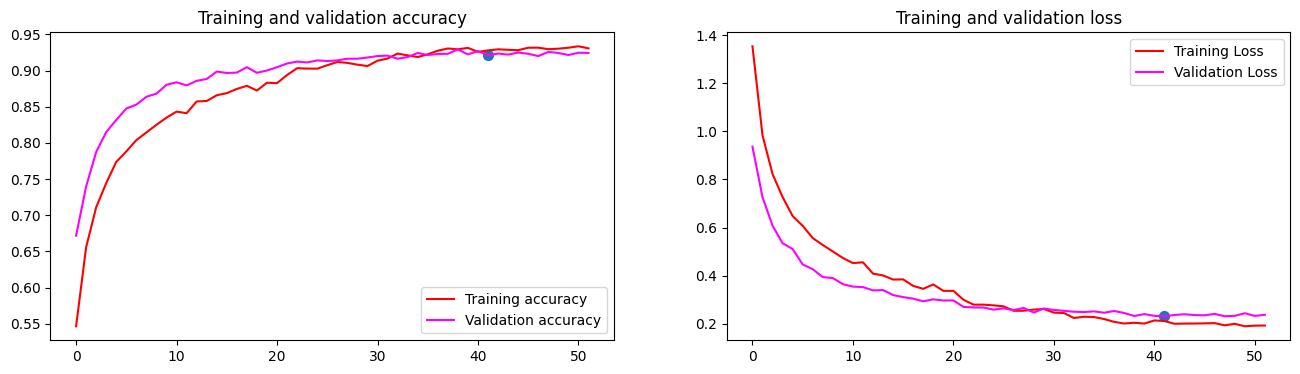

Total Epochs: range(0, 200)


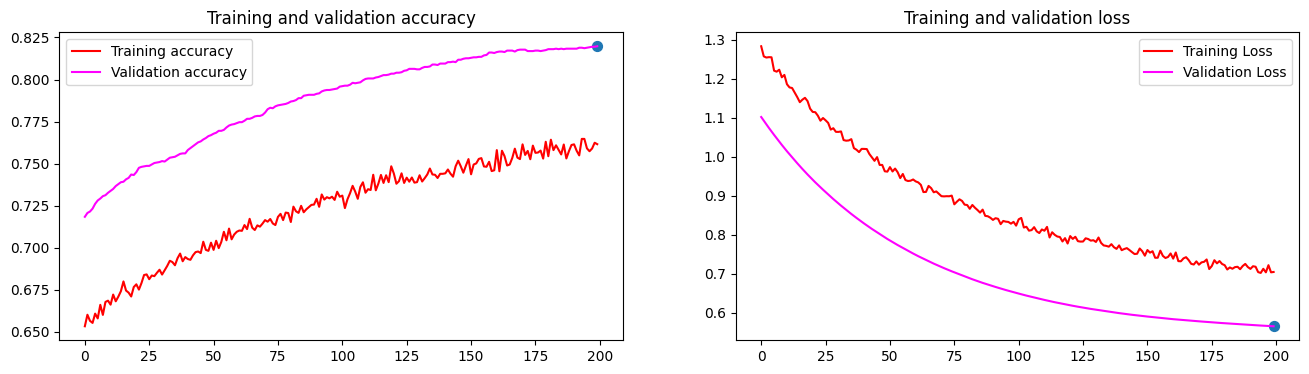

In [27]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

# Evaluations

model.evaluate
110/110 [==============================] - 3s 23ms/step - loss: 0.5648 - accuracy: 0.8198
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.83766   0.57333   0.68074       225
       Lantana    0.87730   0.67136   0.76064       213
   Parkinsonia    0.91729   0.59223   0.71976       206
    Parthenium    0.59600   0.73039   0.65639       204
Prickly acacia    0.63469   0.81132   0.71222       212
   Rubber vine    0.95294   0.80198   0.87097       202
     Siam weed    0.75194   0.90233   0.82030       215
    Snake weed    0.71717   0.69951   0.70823       203
      Negative    0.87027   0.90994   0.88966      1821

      accuracy                        0.81977      3501
     macro avg    0.79503   0.74360   0.75766      3501
  weighted avg    0.82975   0.81977   0.81819      3501


                False Positive Rate  Accuracy
Chinee apple               0.007631  0.573333
Lantana                    0.006083  0.671362
Parkinsonia                0.003338  0.592233
Parthenium                 0.030634  0.730392
Prickly acacia    

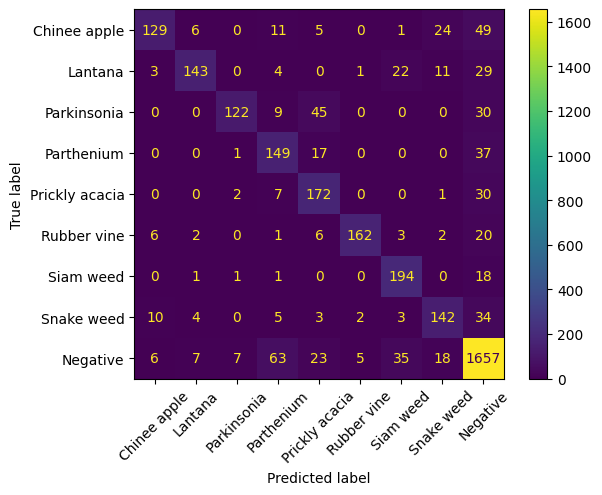

In [28]:
## Computing Positive Threshold Using Validation Dataset
a, b = eval_model(model,validation_generator)

model.evaluate
110/110 [==============================] - 3s 23ms/step - loss: 0.5683 - accuracy: 0.8124
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.83333   0.61947   0.71066       226
       Lantana    0.83030   0.64319   0.72487       213
   Parkinsonia    0.90840   0.57488   0.70414       207
    Parthenium    0.60177   0.66341   0.63109       205
Prickly acacia    0.62094   0.80751   0.70204       213
   Rubber vine    0.91620   0.81188   0.86089       202
     Siam weed    0.72792   0.95814   0.82731       215
    Snake weed    0.71728   0.67157   0.69367       204
      Negative    0.86804   0.89901   0.88326      1822

      accuracy                        0.81238      3507
     macro avg    0.78046   0.73879   0.74866      3507
  weighted avg    0.82074   0.81238   0.81045      3507


                False Positive Rate  Accuracy
Chinee apple               0.008534  0.619469
Lantana                    0.008500  0.643192
Parkinsonia                0.003636  0.574879
Parthenium                 0.027256  0.663415
Prickly acacia    

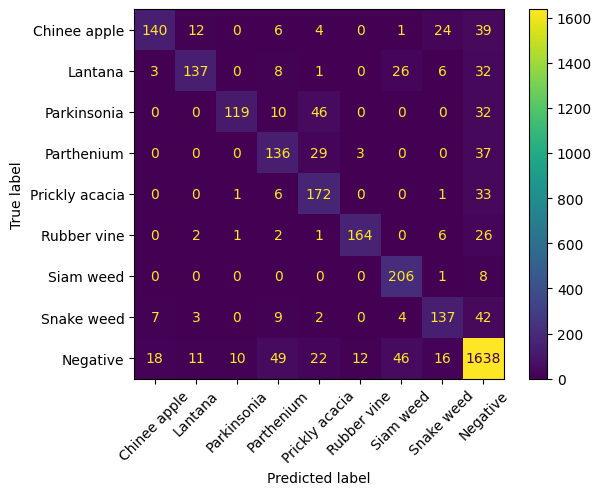

In [29]:
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.68610   0.67699   0.68151       226
       Lantana    0.79558   0.67606   0.73096       213
   Parkinsonia    0.90840   0.57488   0.70414       207
    Parthenium    0.56897   0.64390   0.60412       205
Prickly acacia    0.54416   0.89671   0.67730       213
   Rubber vine    0.89560   0.80693   0.84896       202
     Siam weed    0.71786   0.93488   0.81212       215
    Snake weed    0.71354   0.67157   0.69192       204
      Negative    0.89164   0.84907   0.86983      1822

      accuracy                        0.79470      3507
     macro avg    0.74687   0.74789   0.73565      3507
  weighted avg    0.81280   0.79470   0.79717      3507


                False Positive Rate  Accuracy
Chinee apple               0.021335  0.676991
Lantana                    0.011233  0.676056
Parkinsonia                0.003636  0.574879
Parthenium                 0.030285  0.643902
Prickly acacia    

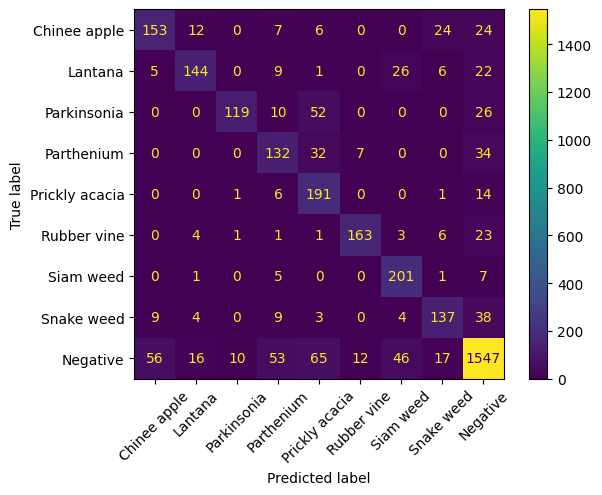

In [30]:
printStats(a,b,0.11)

## Clear Files

In [31]:
shutil.rmtree(base_dir)